# Self-Driving Car Engineer Nanodegree

## Project: Advanced - Finding Lane Lines on the Road

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

### Import packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
import math
%matplotlib inline

# Utility functions
# Check the output of binary filtering
def plot_images(images, titles, cmaps):
    f, axs = plt.subplots(1, len(images), figsize=(24, 9))
    for idx, image in enumerate(images):
        axs[idx].imshow(image, cmap=cmaps[idx])
        axs[idx].set_title(titles[idx], fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def imread_bgr(fname):
    return cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB)

def imread_rgb(fname):
    return mpimg.imread(fname)

def rgb_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def bgr_to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def draw_polygon(img,pts,color=[255,0,0],thickness=5,isClosed=True):
    n = len(pts)
    try:
        for i in range(n-1):
            cv2.line(img,pts[i],pts[i+1],color,thickness) 

        if isClosed == True:
            cv2.line(img,pts[n-1],pts[(0)],color,thickness)
    except :
        print("Error trying to draw line {} {}".format(pts[i],pts[i+1]))
        raise 

def overlay_polygon(img,pts,alpha=1.,beta=1.,gamma=0.):
    overlay = np.zeros_like(img)    
    draw_polygon(overlay,pts)
    return cv2.addWeighted(img,alpha,overlay,beta,gamma)

---
## First, I'll compute the camera calibration using chessboard images

Only 17 images are detected with 9x6 matrix. 
    'camera_cal/calibration14.jpg', 'camera_cal/calibration12.jpg', 'camera_cal/calibration19.jpg', 
    'camera_cal/calibration13.jpg', 'camera_cal/calibration18.jpg', 'camera_cal/calibration6.jpg', 
    'camera_cal/calibration15.jpg', 'camera_cal/calibration10.jpg', 'camera_cal/calibration3.jpg', 
    'camera_cal/calibration16.jpg', 'camera_cal/calibration20.jpg', 'camera_cal/calibration8.jpg', 
    'camera_cal/calibration7.jpg', 'camera_cal/calibration2.jpg', 'camera_cal/calibration17.jpg', 
    'camera_cal/calibration9.jpg', 'camera_cal/calibration11.jpg'
1 found of 9x5 matrix
    'camera_cal/calibration1.jpg'

Other 2 files can not be detected, as their one corner is out of frame causing its nx & ny to be imbalanced from left to right.
    'camera_cal/calibration4.jpg', 'camera_cal/calibration5.jpg'

Thus, I have chosen 9x6 matrix for maximum coverage to calibrate camera.

In [2]:
# calibration done only for one time and pickle file is saved
nx = 9
ny = 6

objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# list of calibration images
cam_cal_images = glob.glob("camera_cal/calibration*.jpg")
fnames = []

for idx, fname in enumerate(cam_cal_images):
    image = cv2.imread(fname)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        fnames.append(fname)
        objpoints.append(objp)
        imgpoints.append(corners)

# print files which are processed
print("Chessboards found: " + str(len(fnames)))

# Find image size
img = cv2.imread('camera_cal/calibration3.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["ret"] = ret
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["rvecs"] = rvecs
dist_pickle["tvecs"] = tvecs
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )


Chessboards found: 17


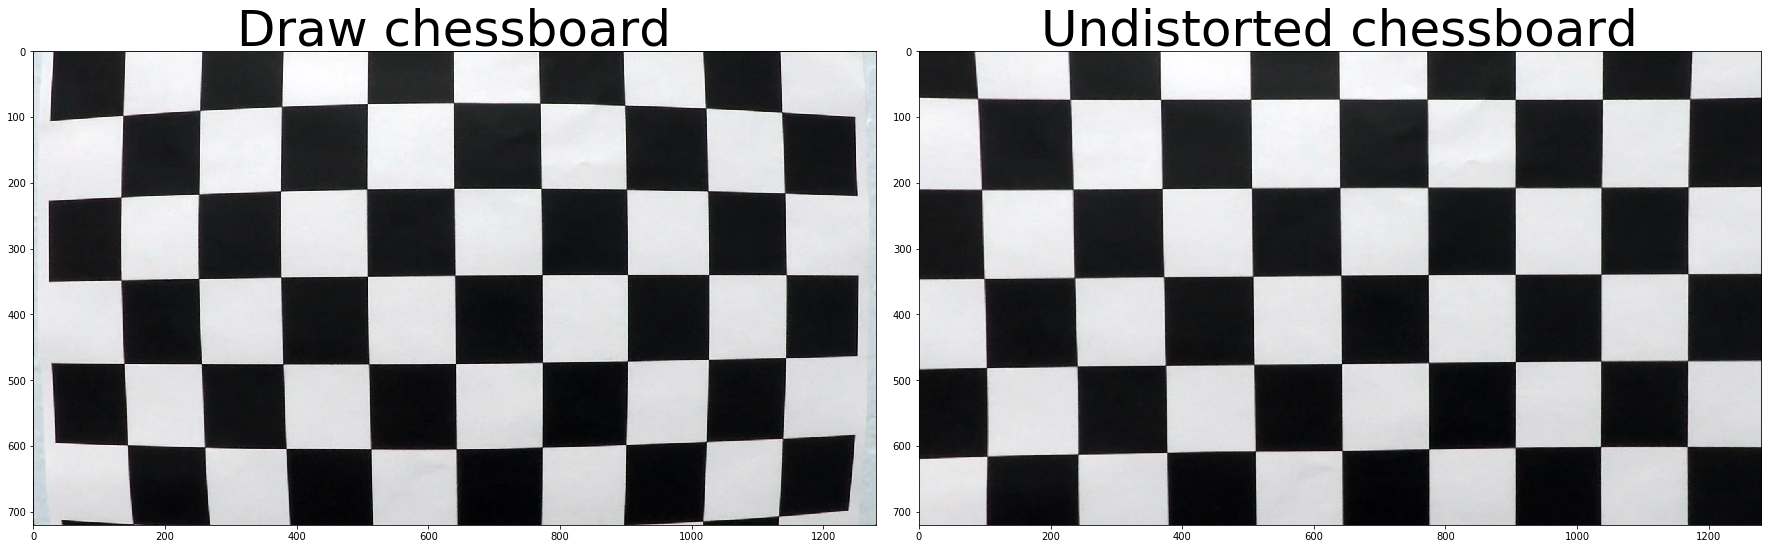

In [29]:
# Find image size
cal3_img = cv2.imread('camera_cal/calibration1.jpg')
cal3_gray = cv2.cvtColor(cal3_img, cv2.COLOR_BGR2GRAY)
img_size = (cal3_img.shape[1], cal3_img.shape[0])

# Draw and display the corners
ret, corners = cv2.findChessboardCorners(cal3_gray, (nx, ny), None)
cv2.drawChessboardCorners(cal3_img, (nx, ny), corners, ret)

# show undistorted image
cal3_undist = cv2.undistort(cal3_img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal3_img)
ax1.set_title('Draw chessboard', fontsize=50)
ax2.imshow(cal3_undist)
ax2.set_title('Undistorted chessboard', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---
### Applying threshold to image for lane detection

In [4]:
# color selection gradient. takes into consideration s of hls & r of rgb
def color_threshold(mp_image, thresh_s = (80, 255), thresh_r = (200, 255)):
    # select s from hls and apply threshold
    hls = cv2.cvtColor(mp_image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_s = np.zeros_like(s_channel)
    binary_s[(s_channel > thresh_s[0]) & (s_channel <= thresh_s[1])] = 1
    
    # select r from rgb and apply threshold
    r_channel = mp_image[:,:,0]
    binary_r = np.zeros_like(r_channel)
    binary_r[(r_channel > thresh_r[0]) & (r_channel <= thresh_r[1])] = 1
    
    # combine to get gradient
    gradient = np.zeros_like(binary_s)
    gradient[(binary_s == 1) & (binary_r == 1)] = 1
    return gradient

# direction gradient
def dir_threshold(img, sobel_kernel = 15, thresh = (0.7, 1.3)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

# magnitude gradient
def mag_threshold(img, sobel_kernel = 3, mag_thresh = (30, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def abs_sobel_thresh(img, orient = 'x', thresh = (0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    scaled_sobel= np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

def sobel_threshold(image):
    x_binary = abs_sobel_thresh(image, thresh=(25, 200))
    y_binary = abs_sobel_thresh(image, orient='y', thresh=(25, 200))
    
    return cv2.bitwise_and(x_binary, y_binary)

# Apply all thresholds to find lane lines
def apply_threshold(mp_image, plot_one=False, plot_two=False):
    cv2_image = cv2.cvtColor(mp_image, cv2.COLOR_RGB2BGR)
    
    cv2_image = cv2.GaussianBlur(cv2_image, (3, 3), 0)
    mp_image = cv2.GaussianBlur(mp_image, (3, 3), 0)
    
    color_binary = color_threshold(mp_image)
    dir_binary = dir_threshold(cv2_image)

    mag_binary = mag_threshold(cv2_image)

    sobel_binary = sobel_threshold(cv2_image)

    gradient_binary = np.zeros_like(color_binary)
    gradient_binary[((sobel_binary == 1) | ((mag_binary == 1) & (dir_binary == 1)))] = 1
    final_binary = cv2.bitwise_or(color_binary, gradient_binary)
    
    if plot_one == True:
        rgb_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
        plot_images([rgb_image, color_binary, dir_binary], ["Original", "Color Threshold", "Direction Threshold"], [None,'gray','gray'])
        plot_images([mag_binary, sobel_binary, final_binary], ["Magnitude Threshold", "Sobel Threshold", "Final Threshold"], ['gray','gray','gray'])

    if plot_two == True:
        rgb_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
        plot_images([rgb_image, final_binary], ["Original", "Final Threshold"], ['gray','gray'])

    return final_binary


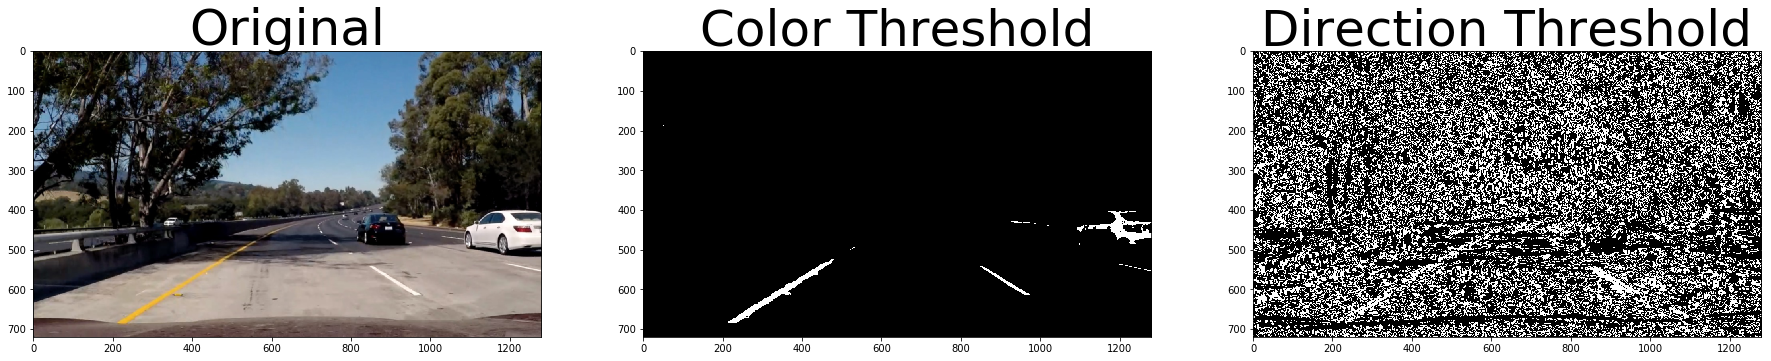

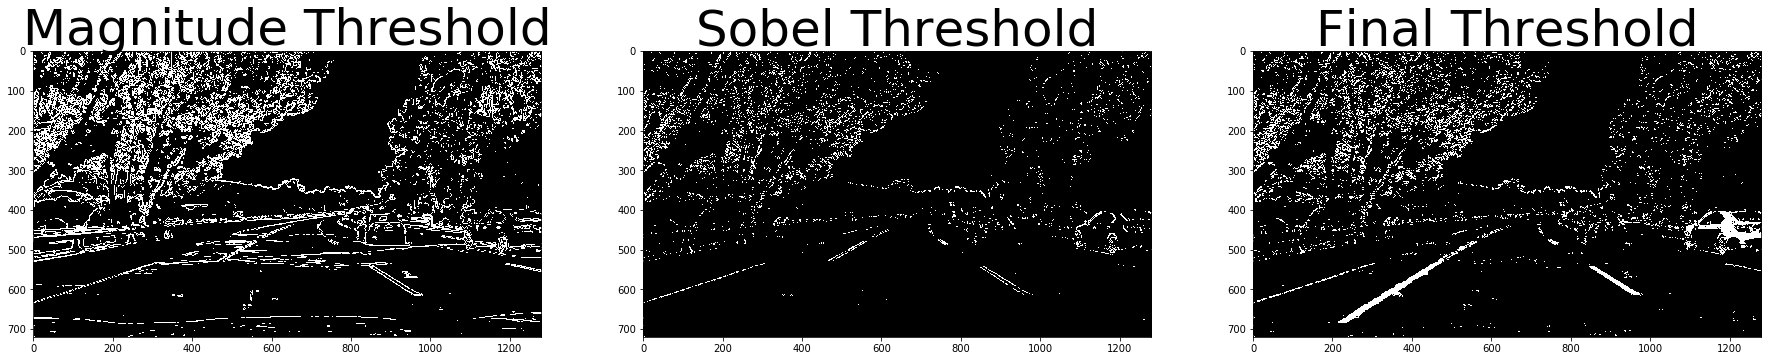

In [5]:
# test image after applying threshold

mp_image = imread_rgb('./test_images/test5.jpg')
cv2_bin_output = apply_threshold(mp_image, plot_one=True)


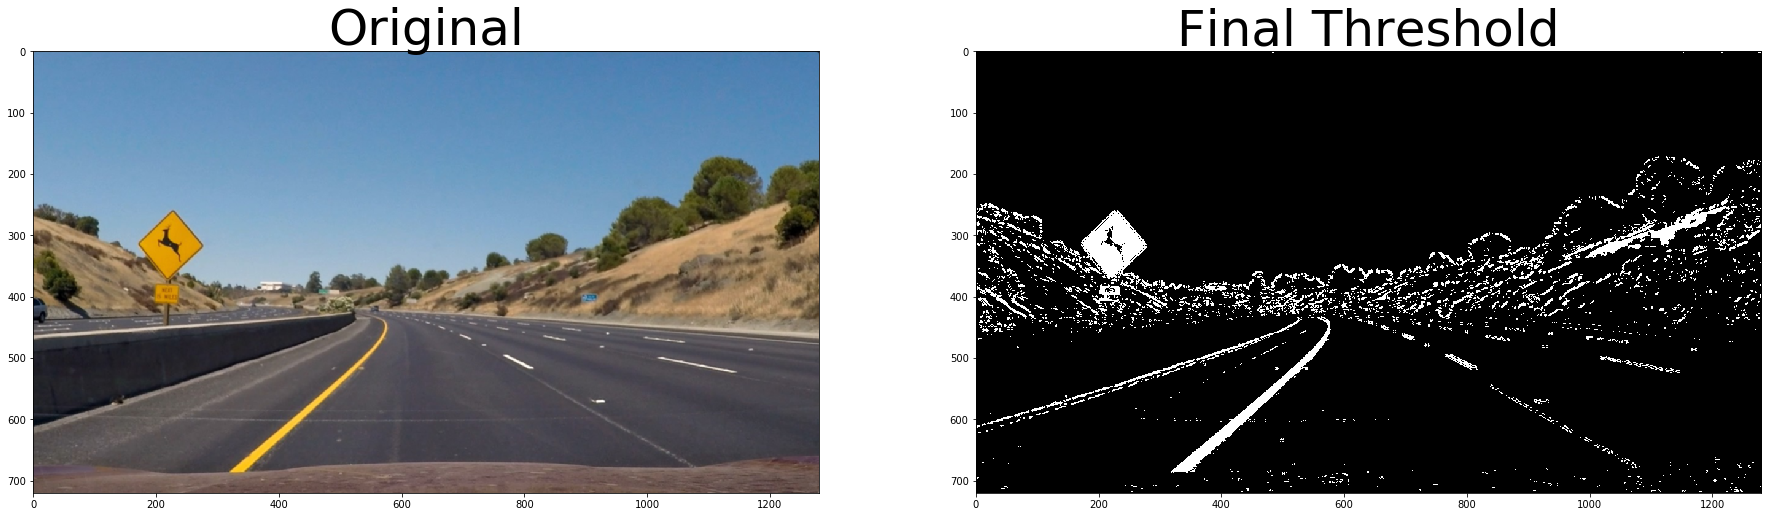

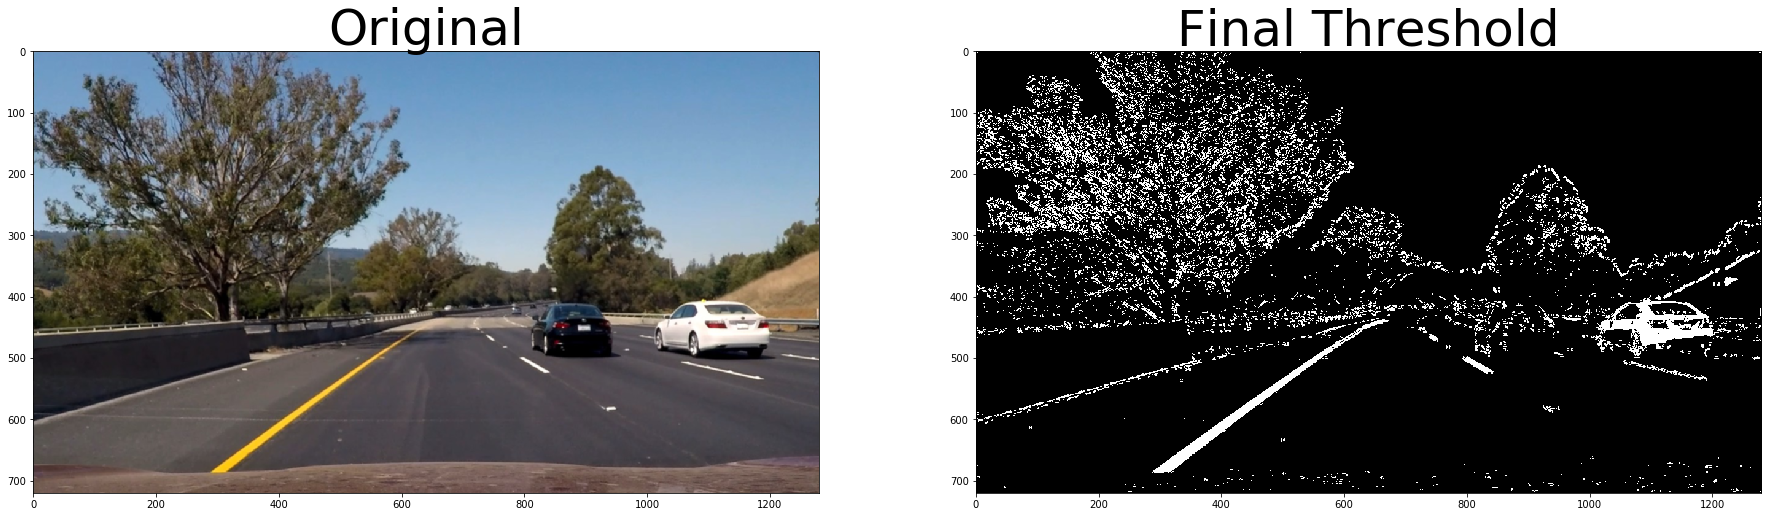

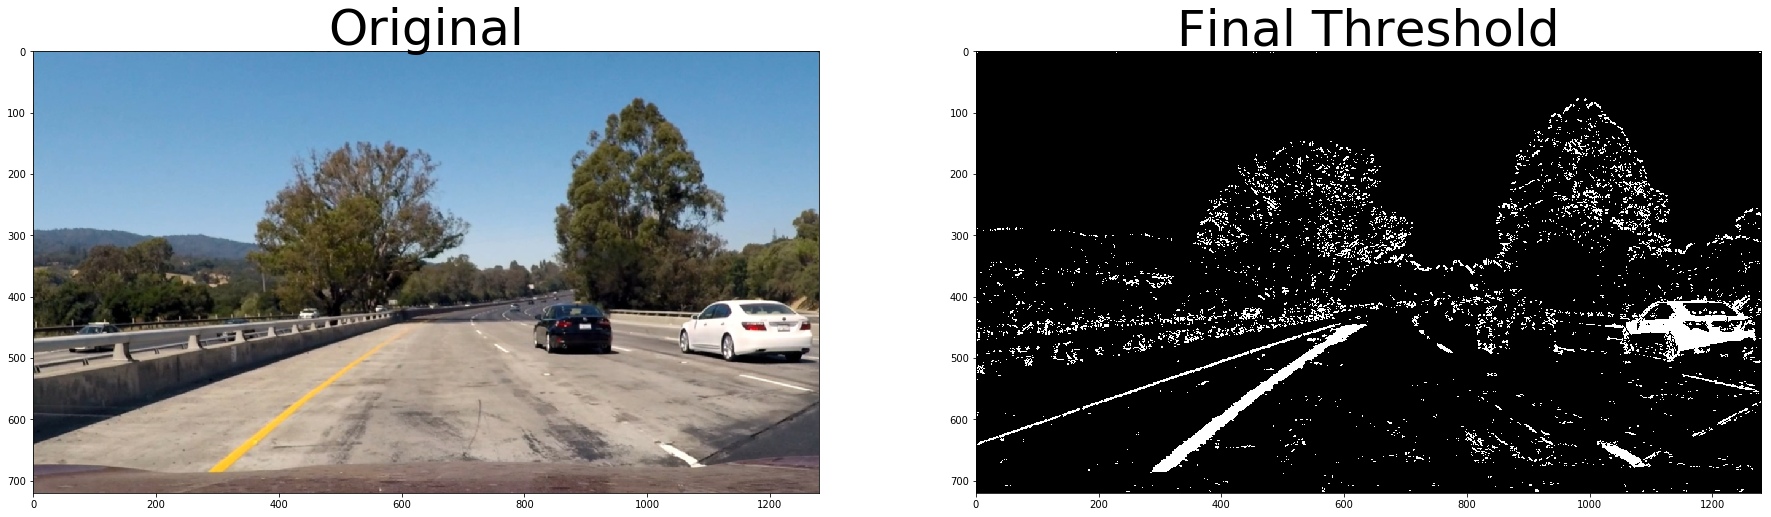

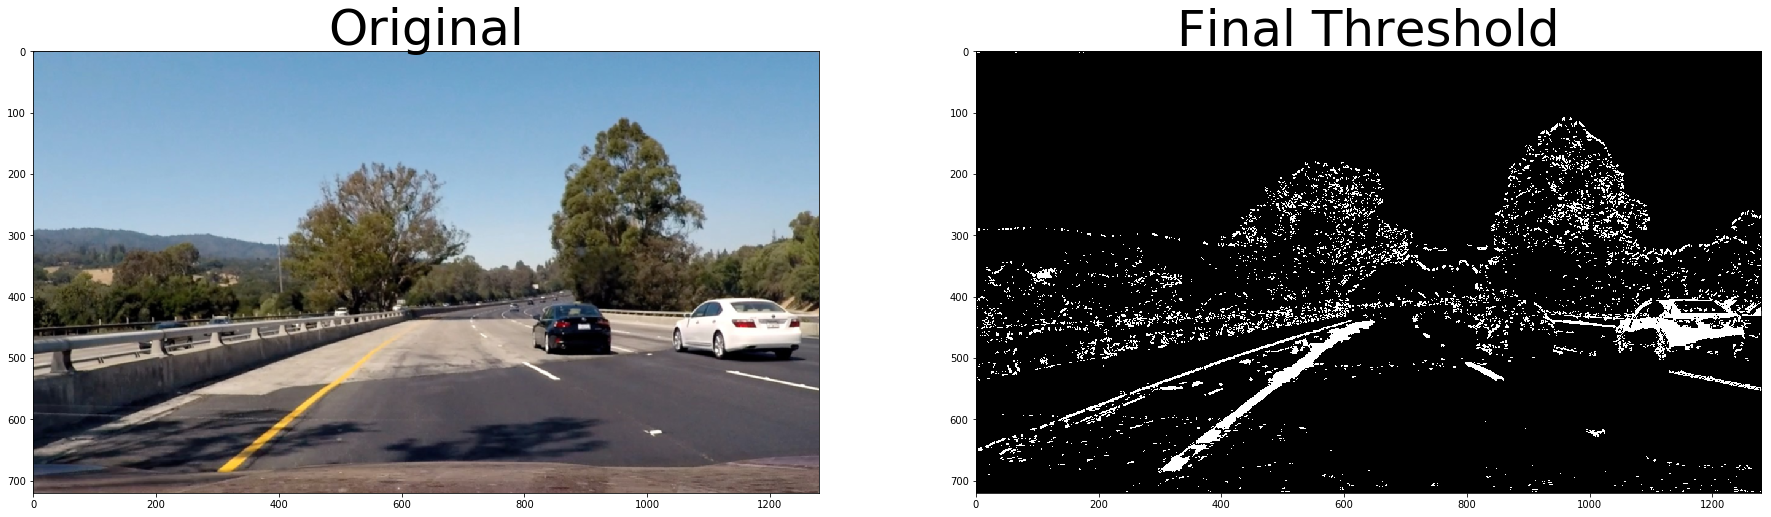

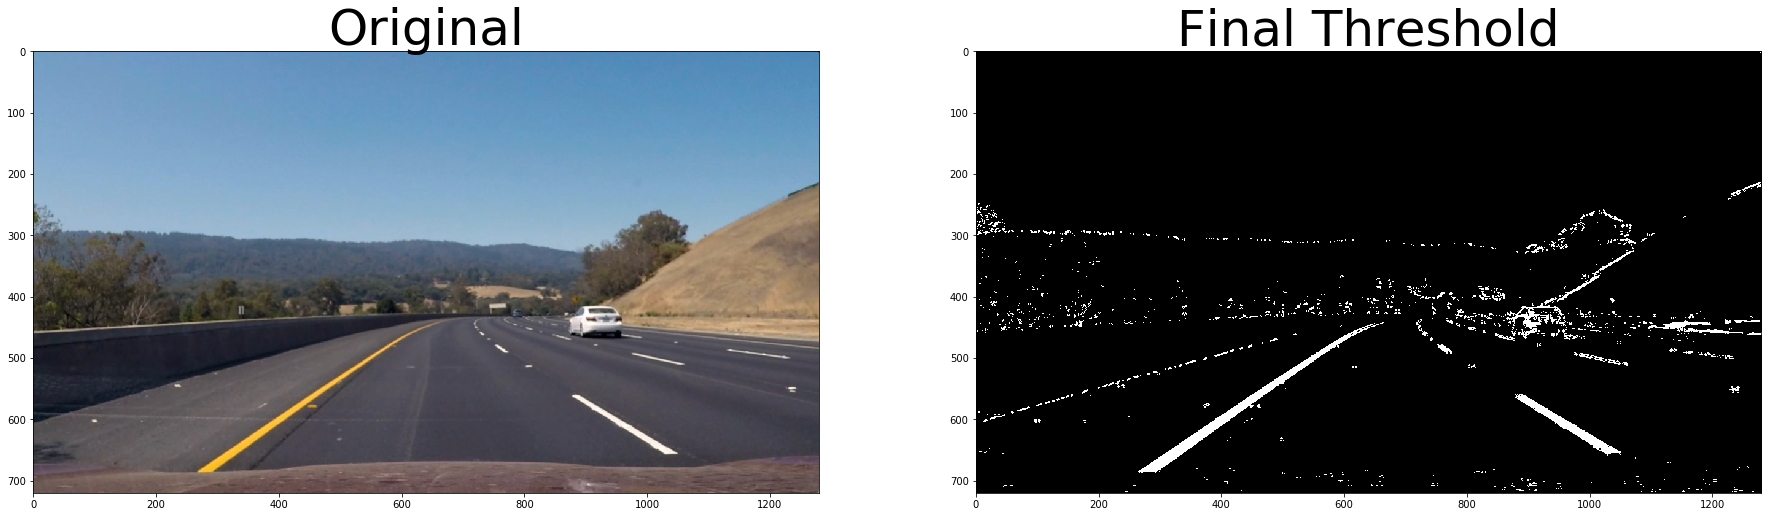

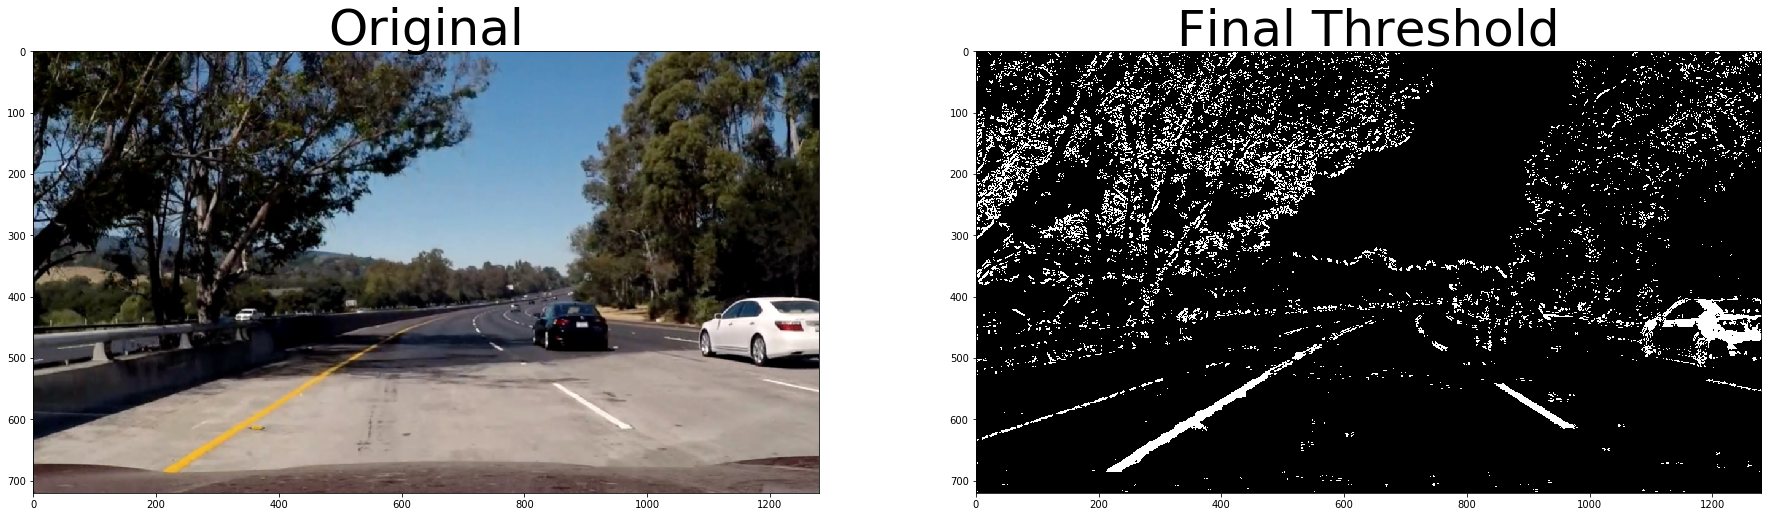

In [6]:
# plot all test images
test_images = glob.glob('./test_images/test*.jpg')
for test_image in test_images:
    mp_image = imread_rgb(test_image)
    cv2_bin_output = apply_threshold(mp_image, plot_two=True)


### Perspective warping to see image from different perspective

In [7]:
def undistort(image):
    # Read in the saved camera matrix and distortion coefficients
    # These are the arrays you calculated using cv2.calibrateCamera()
    # dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p"", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    return cv2.undistort(image, mtx, dist, None, mtx)

def get_perspective_transform(undist_img, src, dst):
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])
    
    # Given src and dst points, calculate the perspective transform matrix
    pt = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
    pt_inv = cv2.getPerspectiveTransform(np.float32(dst), np.float32(src))
    return pt, pt_inv

def warp_perspective(undist_img, pt):
    # Grab the image shape
    img_size = (undist_img.shape[1], undist_img.shape[0])
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist_img, pt, img_size)
        
    # Return the resulting image and matrix
    return warped


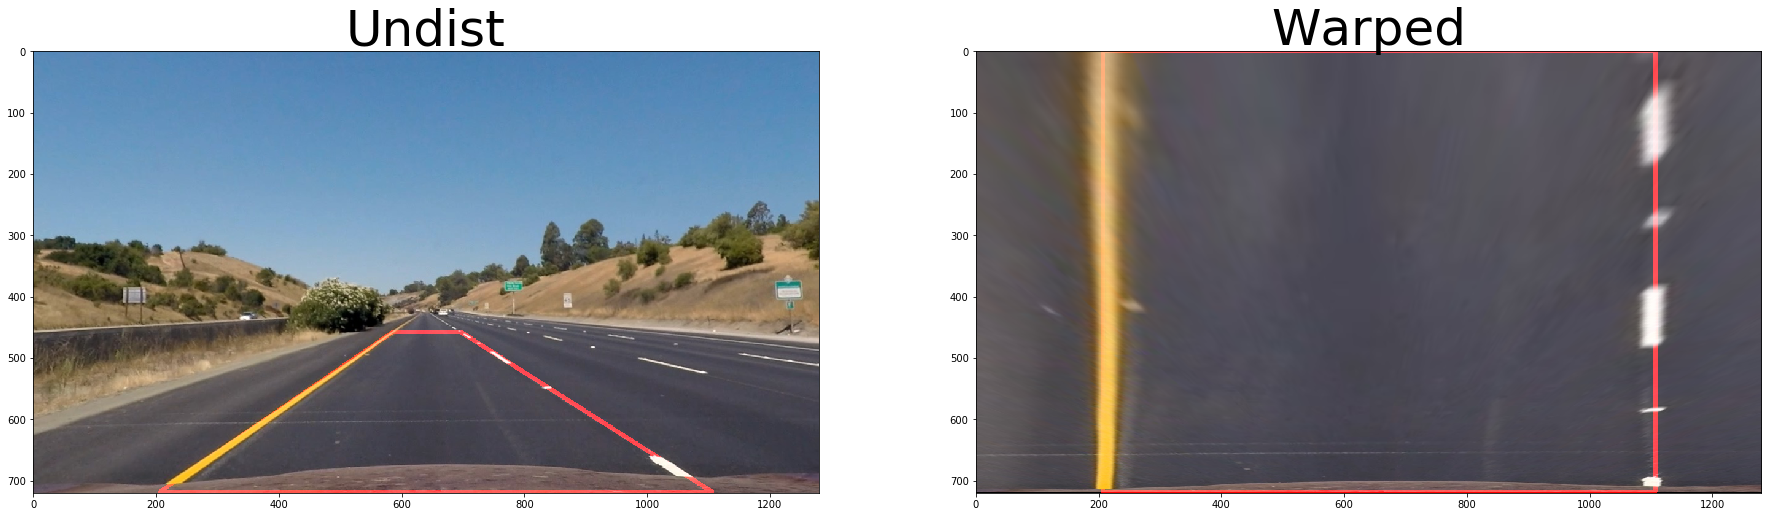

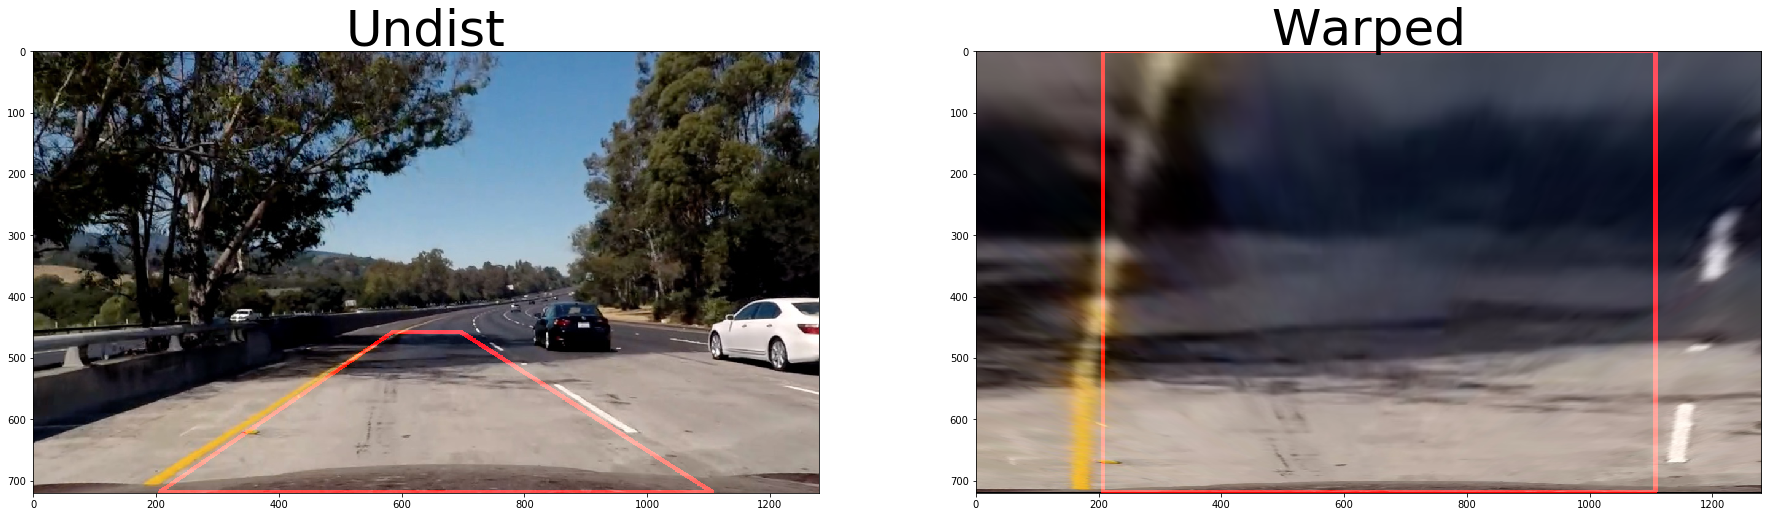

In [15]:
# Points seleted by manual inspetion of reference path.
perspective_src_pts = [(206,718), (586,457), (696,457), (1106,718)]
perspective_dst_pts = [(206,718), (206,0), (1106,0), (1106,718)]

# Reference image.
test_img = imread_rgb('test_images/straight_lines1.jpg')
undist_img = undistort(test_img)

# Find perspective transform.
pt, pt_inv = get_perspective_transform(undist_img,perspective_src_pts,perspective_dst_pts)

# apply perspective transform
warped = warp_perspective(undist_img, pt)
plot_images([overlay_polygon(undist_img,perspective_src_pts), overlay_polygon(warped,perspective_dst_pts)], ["Undist", "Warped"], [None,None])

test_img = imread_rgb('test_images/test5.jpg')
undist_img = undistort(test_img)
warped = warp_perspective(undist_img, pt)
plot_images([overlay_polygon(undist_img,perspective_src_pts), overlay_polygon(warped,perspective_dst_pts)], ["Undist", "Warped"], [None,None])


### Sliding window
First get histogram of undistorted & warped image. Using this histogram, search for lane curvature with the help of curve fitting (polyfit) & sliding window.

In [72]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

def find_lane_pixels(binary_warped, draw_rec=False):
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        if draw_rec:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

# call this method on first frame to fit left & right
def fit_polynomial(binary_warped, draw_rec=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, draw_rec)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    if draw_rec:
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

# Then call this method from 2nd frame onwards
def search_around_poly(binary_warped, left_fit, right_fit, plot_lines=False):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 90

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    #result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # fill polygon with color
    #window_img = np.dstack((window_img,window_img,window_img)) * 255
    
    draw_polygon(window_img,left_line_pts,color=[0,255,0],isClosed=False,thickness=20)
    draw_polygon(window_img,right_line_pts,color=[0,0,255],isClosed=False,thickness=20)
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if plot_lines:
        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##
    
    return result, left_fitx, right_fitx

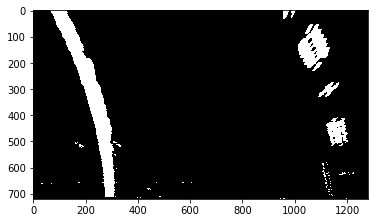

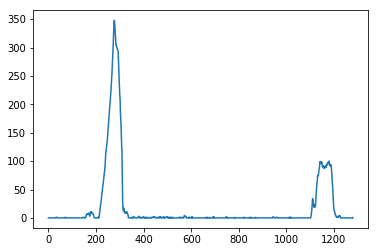

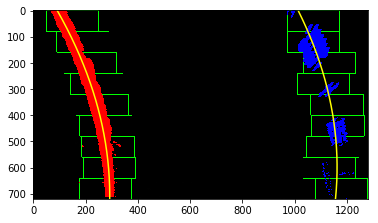

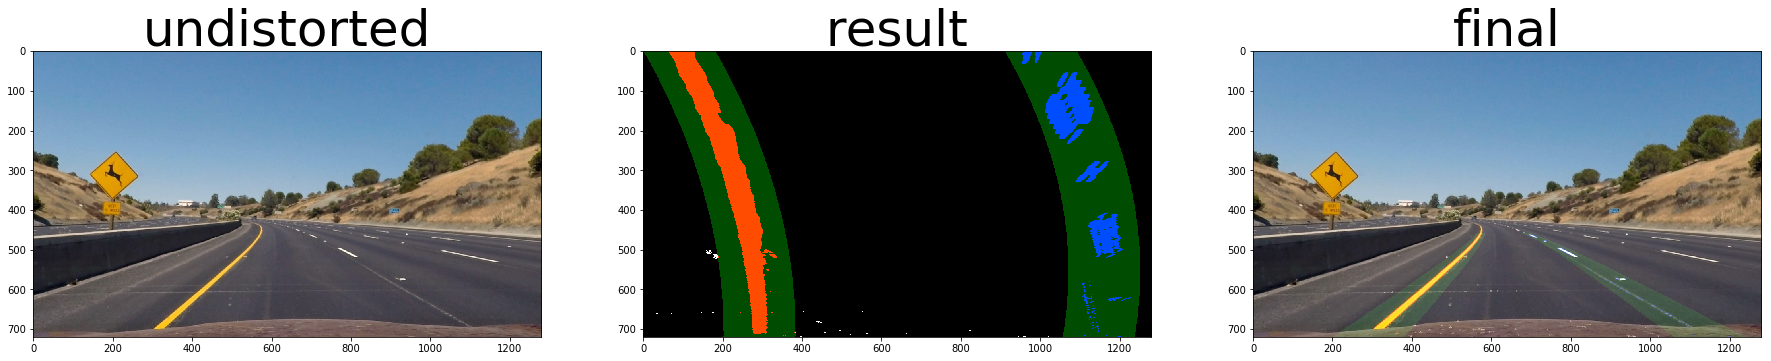

In [73]:
# Plot histogram
test_img = imread_rgb('test_images/test2.jpg')
undist_img = undistort(test_img)
thresh_img = apply_threshold(undist_img)
warped = warp_perspective(thresh_img, pt)


plt.imshow(warped, cmap='gray')
plt.show()

# Create histogram of image binary activations
histogram = hist(warped)

# Visualize the resulting histogram
plt.plot(histogram)
plt.show()

out_img, left_fit, right_fit = fit_polynomial(warped, True)
plt.imshow(out_img)
plt.show()

result, left_fit, right_fit = search_around_poly(warped, left_fit, right_fit)
result_inv = warp_perspective(result, pt_inv)
final = cv2.addWeighted(undist_img,1.0,result_inv,0.3,0.0)

plot_images([undist_img,result,final], ["undistorted","result", "final"], [None,None,None])

### Measuring curvature

In [253]:
def measure_curvature_real(ploty, ym_per_pix, xm_per_pix):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Add radius and displacement to the frame image.
    cv2.putText(undistorted,
                "Radius: {:0.2f} m".format(radius),
                (400,650),
                cv2.FONT_HERSHEY_PLAIN,
                 3.,
                [0,255,0],5)

    cv2.putText(undistorted,
                "Displacement: {:0.2f} cm".format(displacement*100),
                (400,680),
                cv2.FONT_HERSHEY_PLAIN,
                 2.5,
                [0,255,0],5)
    
    return left_curverad, right_curverad

In [254]:
# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real()

print(left_curverad, 'm', right_curverad, 'm')

533.752588921 m 648.157485143 m


## Core Logic
To start with image pipeline
1. By now, camera calibration is already done and should be ready to use
2. First undistort the image
3. then apply threshold
4. then apply warp pespective transform
5. then apply fit_polynomial for first image and get left_fit & right_fit polynomial data
6. Then using left_fit & right_fit apply search_around_poly for rest of the images
7. For each frame, calculate curvature
    Determine the curvature of the lane and vehicle position with respect to center.
8. Warp the detected lane boundaries back onto the original image.
9. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [44]:
def image_pipeline(image):
    global left_fit
    global right_fit
    undist_img = undistort(image)
    thresh_img = apply_threshold(undist_img)
    warped = warp_perspective(thresh_img, pt)
    
    if left_fit is None:
        result, left_fit, right_fit = fit_polynomial(warped)
    else:
        result = search_around_poly(warped, left_fit, right_fit)
        
    result_inv = warp_perspective(result, pt_inv)
    result = cv2.addWeighted(undist_img,1.0,result_inv,0.3,0.0)
    return result


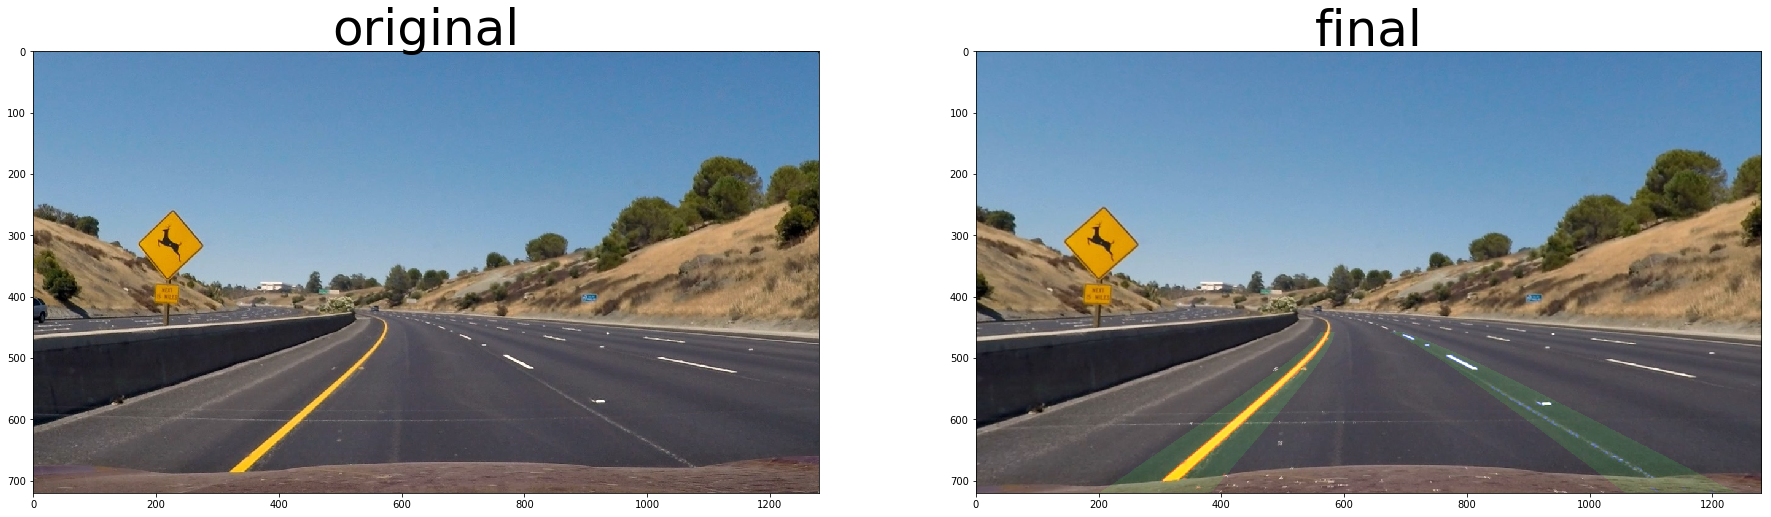

In [45]:
# test pipeline
test_img = imread_rgb('test_images/test2.jpg')
result = image_pipeline(test_img)

plot_images([test_img,result],["original","final"],[None,None])

### Video processing pipeline

AttributeError: 'tuple' object has no attribute 'shape'

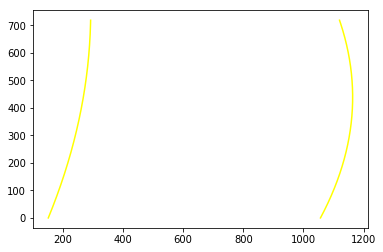

In [279]:
from moviepy.editor import VideoFileClip

in_clip = VideoFileClip('project_video.mp4').subclip(0,5)

out_filename = 'processed-project_video.mp4'
left_fit = None
right_fit = None

out_clip = in_clip.fl_image(lambda image: image_pipeline(image))

out_clip.write_videofile(out_filename,audio=False)


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))